In [1]:
%load_ext autoreload
%autoreload 2

# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics (correlation)
from scipy.stats import pearsonr, spearmanr

# libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
# custom functions
from pt_helpers import *

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [32]:
data_path = "DATA/training_data/"

df = pd.read_csv(data_path + "VEX_edac_mag_labeled.csv")

In [4]:
df.head()

,DATE_TIME,EDAC,BX,BY,BZ,BT,XSC,YSC,ZSC,RSC,cme
0,2006-04-24 00:00:00,0,12.357658,-1.304164,-3.332425,12.881274,-4451.055178,-3196.485753,-65466.762260,65695.760575,0
1,2006-04-24 00:05:00,0,12.868947,-0.980800,-3.360027,13.340680,-4202.246280,-3138.377907,-65806.350827,66015.078600,0
2,2006-04-24 00:10:00,0,12.857438,-0.871986,-3.487877,13.355384,-3954.000329,-3080.233288,-66137.913808,66327.612616,0
3,2006-04-24 00:15:00,0,12.898635,-0.684986,-2.885689,13.248405,-3705.057257,-3021.761270,-66463.291041,66635.079608,0
4,2006-04-24 00:20:00,0,12.766473,-0.517608,-2.217135,12.972905,-3453.676541,-2962.553108,-66784.717784,66939.596338,0


We separate the feature matrix `X` and the labels `y`.
- `X` will only contain BT data

In [5]:
y = df['cme'].values
X = df['BT'].values

In [6]:
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)

Shape of y: (893069,)
Shape of X: (893069,)


## Feature correlation
We look at correlation between BT and CME features using:
- Pearson Correlation Coefficient: this measures the linear correlation between two variables. It ranges from -1 to +1, with -1 indicating a perfect negative linear correlation, +1 indicating a perfect positive linear correlation, and 0 indicating no linear correlation.
- Spearman's Rank Correlation: if the data is not normally distributed or the relationship is not linear, Spearman's rank correlation, which assesses monotonic relationships, might be more appropriate.

We will look at both

In [16]:
pearson_corr, _ = pearsonr(df['BT'], df['cme'])
spearman_corr, _ = spearmanr(df['BT'], df['cme'])

In [17]:
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

Pearson Correlation Coefficient: 0.21181379861159677
Spearman Correlation Coefficient: 0.1672314453462077


- Pearson Correlation Coefficient: A value of around 0.21 suggests a low to moderate positive linear correlation. This means that as the total magnetic field increases, the frequency of CME occurrences also tends to increase slightly. However, the correlation is not very strong, indicating that other factors are likely at play or that the relationship is not purely linear.

- Spearman Correlation Coefficient: The Spearman coefficient, which measures the monotonic relationship, is slightly lower at 0.1672. This suggests that while there is a tendency for CME occurrences to increase with the total magnetic field, the relationship is not strongly monotonic, and other variables or a combination of factors might better explain the occurrence of CMEs.

Both coefficients being positive but not very high implies that while there is some association, the total magnetic field alone may not be a strong predictor for CME occurrences. It could still be a useful feature in a predictive model, especially when combined with other relevant features that might collectively have a stronger relationship with CME occurrences.

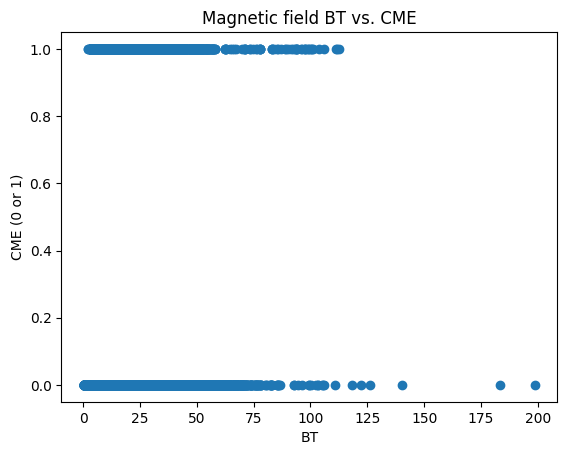

In [18]:
plt.scatter(df['BT'], df['cme'])
plt.xlabel('BT')
plt.ylabel('CME (0 or 1)')
plt.title('Magnetic field BT vs. CME')
plt.show()

## LSTM

In [19]:
# Create the sequences with a window size of 36 (3 hours at 5 minutes per interval)
window_size = 36  # 3 hours * 60 minutes / 5 minutes per interval
X_sequence, y_sequence = create_sliding_window_sequences(X, y, window_size)

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequence, y_sequence, test_size=0.2, random_state=42)

In [21]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train[:, :, np.newaxis], dtype=torch.float32)  # Adding an extra dimension for LSTM input
y_train_tensor = torch.tensor(y_train[:, np.newaxis], dtype=torch.float32)  # Adding an extra dimension for LSTM output
X_test_tensor = torch.tensor(X_test[:, :, np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[:, np.newaxis], dtype=torch.float32)

In [22]:
# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Instantiate the model
hidden_dim = 64
num_layers = 1
model = CMEPredictorLSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=num_layers)

# Define the loss function and optimizer
criterion = nn.BCELoss() # Default
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training and evaluation

In [25]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.07329125702381134
Epoch 2/10, Loss: 0.15613923966884613
Epoch 3/10, Loss: 0.12608815729618073
Epoch 4/10, Loss: 0.03276734799146652
Epoch 5/10, Loss: 0.09759967774152756
Epoch 6/10, Loss: 0.10379285365343094
Epoch 7/10, Loss: 0.01928599178791046
Epoch 8/10, Loss: 0.014921296387910843
Epoch 9/10, Loss: 0.025898003950715065
Epoch 10/10, Loss: 0.08730750530958176


In [26]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_true = y_test_tensor.numpy()
    y_pred = model(X_test_tensor).numpy()
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9825
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/home/agatha/Anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LSTM with class weights

In [27]:
# Calculate the class weights for imbalanced classes
class_counts = df['cme'].value_counts().sort_index().values
weight_for_1 = (1 / class_counts[1]) * (len(df) / 2.0)
weights = torch.tensor([weight_for_1], dtype=torch.float32)

# Define the weighted loss function with pos_weight for the positive class
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

In [30]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass, use model with logits output (not passing through sigmoid)
        outputs = model(inputs).squeeze()
        
        # Compute the loss, labels should be float and no need to squeeze if they are already 1D
        loss = criterion(outputs, labels.float().view(-1))

        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/10, Loss: 1.3174335956573486
Epoch 2/10, Loss: 1.1923933029174805
Epoch 3/10, Loss: 0.7364987134933472
Epoch 4/10, Loss: 1.3347870111465454
Epoch 5/10, Loss: 1.0738720893859863
Epoch 6/10, Loss: 0.7359983325004578
Epoch 7/10, Loss: 0.7458798885345459
Epoch 8/10, Loss: 0.7567148804664612
Epoch 9/10, Loss: 1.0594091415405273
Epoch 10/10, Loss: 0.876548171043396


In [33]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_true = y_test_tensor.numpy()
    y_pred = model(X_test_tensor).numpy()
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate metrics
accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9111
Precision: 0.1124
Recall: 0.5913
F1 Score: 0.1888
